# FlagCloud

The goal of this project is to create a word cloud of 500 biggest cities for each country provided. The font size for each city name should be proportional to its population, and the colors should match those as if the names of the cities were superimposed on the national flag of that country.

The names of the countries are provided from the user as the input. The rest of the information is downloaded from the Internet.

## Steps:

1. Download flags for each country.
2. Collect information for 500 biggest cities in each country: their names and population.
3. Create a Word Cloud of city names for each country.
4. Concatenate the national flag and the Word Cloud flag to be on the same image.

Note: The user should provide both the name of the country and its abbreviation as a dictionary, for example: {'ES': 'Spain'}. Both versions of the name are used throughout the code.

### Python libraries used

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from bs4 import BeautifulSoup
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import csv

### Download flags

The flags are downloaded from Flagpedia website.

Note: It is important to check the name of the country used on Flagpedia, as some countries might have more than one version of its official name. Also, please be careful with the spelling. Some country names contain special characters.

The following function is used to download the flags:

In [15]:
def download_flags(countries: dict):
    """ Download flags for the countries from Flagpedia. """
    for country in countries.values():
        page = urllib.request.urlopen(f"https://flagpedia.net/{country}")
        soup = BeautifulSoup(page)
        imgURL = "https://flagpedia.net" + soup.find("img", {"alt": f"Flag of {country}"})["src"]

        # Save image to file
        urllib.request.urlretrieve(imgURL, f"in_data/img/{country}.png")

### Biggest cities and their population

The list of the biggest cities for each country with their population is taken from geoba.se website. If a country has less than 500 cities, the maximum number of cities available will be used.

The following function is used to collect the data. The output is stored in a separate CSV file for each country.

In [16]:
def get_cities_data(countries: dict):
    """ Get 500 biggest cities for each country with their population from Geoba.se. """
    for country in countries.keys():
        cities = {} # {"City": population}
        for page_num in range(1, 6):
            page = urllib.request.urlopen(f"http://www.geoba.se/population.php?cc={country}&st=city_rank_country&asde=&page={page_num}")

            soup = BeautifulSoup(page, "html.parser")
            rows = soup.find_all("tr", class_="bb")

            for row in rows:
                name = row.find("a", class_="redglow")
                population = row.find("td", align="right")
                cities[name.contents[0]] = int(population.text.replace(",", ""))

            # Save data to a CSV file
            with open(f"out_data/csv/{countries[country]}.csv", "w", newline="", encoding="utf-8") as f:
                writer = csv.writer(f)
                for row in cities.items():
                    writer.writerow(row)

### Create Word Clouds

Next, a Word Cloud is created for each country. The **wordcloud** library is used.

The result is being saved as a PNG image.

Note: The original flag dimentions are kept.

In [17]:
def create_wordcloud(countries: dict):
    """ Create FlagCloud for each country and save it to file. """
    for country in countries.keys():
        # Read data from CSV file
        cities = {}
        with open(f"out_data/csv/{countries[country]}.csv", encoding="utf-8") as file:
            for line in file:
                entry = line.split(',')
                city = str(entry[:-1][0])
                population = int(entry[-1])
                cities[city] = population

        # Open the image of a flag
        image =Image.open(f"in_data/img/{countries[country]}.png")
        w, h = image.size
        image = image.convert("RGBA")

        # Create a mask array
        mask = np.array(image)

        # Creare a FlagCloud image 
        flag_cloud = WordCloud(background_color="white", mode="RGBA", max_words=1000, mask=mask)
        flag_cloud.generate_from_frequencies(frequencies=cities)
        image_colors = ImageColorGenerator(mask)

        # Match the original size and colors
        px = 1/plt.rcParams["figure.dpi"]  # pixel in inches    
        plt.figure(figsize=(w * px, h * px))
        plt.imshow(flag_cloud.recolor(color_func=image_colors), interpolation="None")
        plt.axis("off")

        # Stretch the image to get rid of the white margins
        plt.tight_layout(rect=(-0.04, -0.04, 1.04, 1.04))

        # Save word cloud to file
        plt.savefig(f"out_data/cloud_img/{countries[country]}.png", format="png")

### Concatenate images

In the last step, the national flag and the Word Cloud generated previously are placed on the same picture next to each other. **PIL** library is used to do that.

In [18]:
def concat_pictures(countries: dict):
    """ Concatenate two flags: the original flag and WordCloud flag. """
    # Parameters
    margin = 20
    bg_color = "black"

    for country in countries:
        # Open images to concatenate
        images = [Image.open(img) for img in [f"in_data/img/{countries[country]}.png", f"out_data/cloud_img/{countries[country]}.png"]]
        widths, heights = zip(*(img.size for img in images))

        # Calculate the size of the resulting image
        total_width = sum(widths) + margin * 3
        max_height = max(heights) + margin * 2

        # Create the resulting image
        new_im = Image.new("RGB", (total_width, max_height), color=bg_color)

        # Concatenate images
        x_offset = margin
        for img in images:
            new_im.paste(img, (x_offset, margin))
            x_offset += img.size[0] + margin

        # Save image to file
        new_im.save(f"out_data/final_img/{countries[country]}.png")

## Top level code

In the following top level code we provide the dictionary with countries we want to create the FlagCloud for and perform the formation of the output.

None: If you want to run this code locally, please make sure you have the following directories created: in_data/img, out_data/cloud_img, out_data/final_img, out_data/csv

In [ ]:
# List of countries to create FlagClouds for
countries = {'ES': 'Spain', 'PT': 'Portugal', 'BR': 'Brazil', 'RO': 'Romania', 'AU': 'Australia'}

download_flags(countries)

get_cities_data(countries)

create_wordcloud(countries)

concat_pictures(countries)

### Display the results

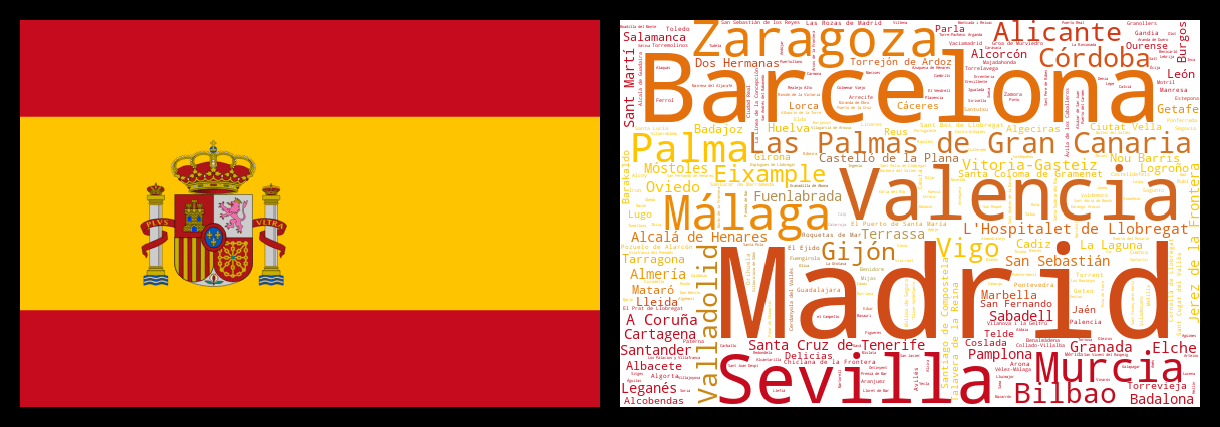

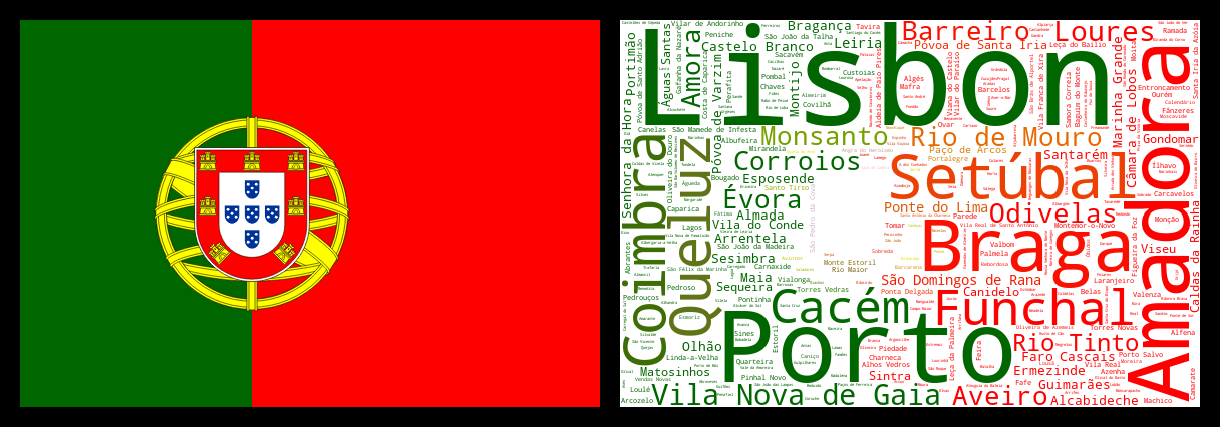

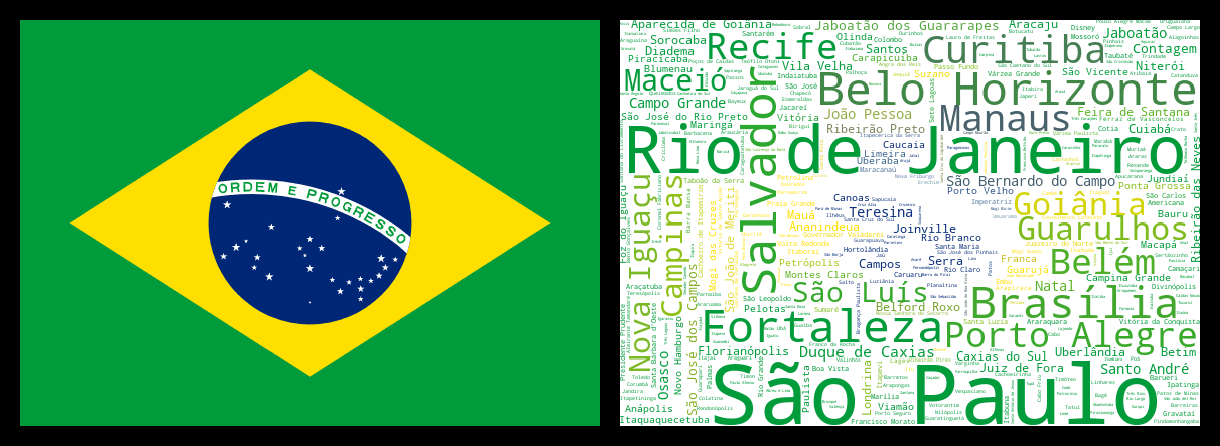

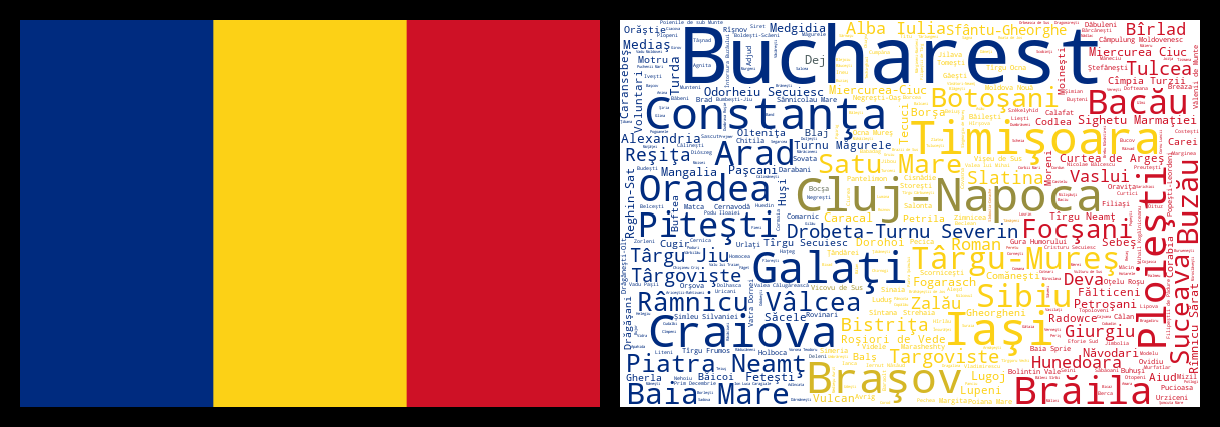

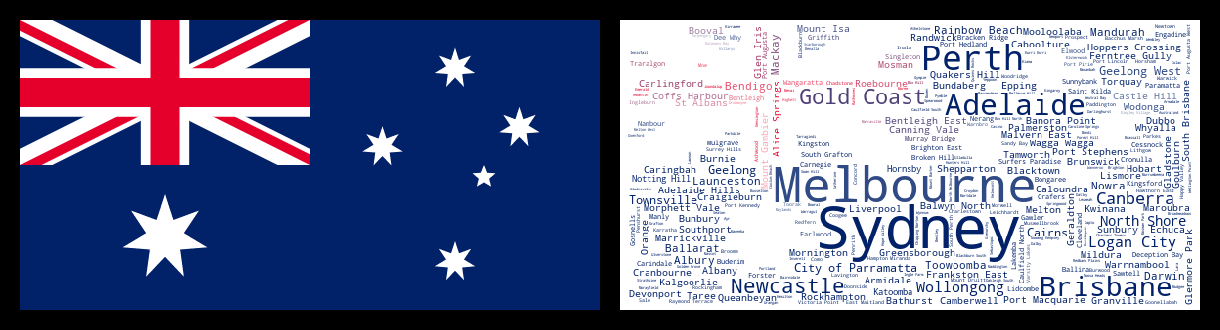

In [20]:
for country in countries:
    image = Image.open(f"out_data/final_img/{countries[country]}.png")
    display(image)